In [2]:
from zipfile import ZipFile
# import scikit-iag
import numpy as np
import matplotlib.pyplot as plt
import glob 
from skimage import io
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
import cv2
import pandas as pd



# Steps for iris recognition
    1)Image Acquisition
    2)Image Segmentation 
    3)Normalization and Feature Extraction
    4)Matching(Hamming Distance)


    Datasets used
    •LG 2200 2008 
    •LG 4000 
    •LG 2200 2010 

# Preparing the dataset 

In [ ]:
def data_prep(filename):
    data = {'images':dict(),'description':dict()}
    zf = ZipFile(filename)
    split_value = []
    for i in range(len(zf.namelist())):
        current = zf.namelist()[i]
        imagelist = []
        if(".tiff" in current):
            split_value = current.split('/')
            if split_value[1] not in data['images'].keys():
                data['images'].update({split_value[1]:[]})
            data['images'][split_value[1]].append(current)
        elif(".txt" in current):
            split_value = current.split('/')
            if split_value[1] not in data['description']:
                data['description'].update({split_value[1]:list(pd.DataFrame())})
            file = zf.open(current)
            df = pd.read_csv(file, sep="\t", header=None,names=['attributes','type','value'])
            for k in range(0,len(df),55):
                data['description'][split_value[1]].append(df[k:k+55])
    zf.close()
    return data

In [3]:
gallery = data_prep('dataset\Zip Dataset\LG2200-2008-03-11_13.zip')
probe_1 = data_prep('dataset\Zip Dataset\LG2200-2010-04-27_29.zip')
probe_2 = data_prep('dataset\Zip Dataset\LG4000-2010-04-27_29.zip')
print(gallery['images'].keys())
print('\n',gallery['description'].keys())

print('\n',gallery['images']['02463'][0])

dict_keys(['02463', '04233', '04252', '04261', '04267', '04327', '04385', '04394', '04397', '04470', '04537', '04629', '04815', '04851', '04888', '04917', '05015', '05028', '05033', '05044', '05136', '05156', '05176', '05186', '05191', '05204', '05213', '05232', '05244', '05248', '05256', '05271', '05284', '05288', '05289', '05290', '05292', '05298', '05300', '05301', '05303', '05304', '05305', '05306', '05308', '05310', '05314', '05317', '05320', '05321', '05324', '05337', '05341', '05344', '05355', '05366', '05368', '05379', '05386', '05392', '05399', '05401', '05405', '05406', '05407', '05408', '05409', '05412', '05415', '05430', '05441', '05442', '05444', '05445', '05447', '05448', '05450', '05454', '05455', '05456', '05457', '05459', '05460', '05461', '05462', '05463', '05465', '05466'])

 dict_keys(['02463', '04233', '04252', '04261', '04267', '04327', '04385', '04394', '04397', '04470', '04537', '04629', '04815', '04851', '04888', '04917', '05015', '05028', '05033', '05044', '05

# Dataset Contents and Description

In [4]:
gallery['description']['02463'][0]

,attributes,type,value
0,id,numeric,185614
1,recordingid,string,nd5R68398
2,shotid,string,2008_071_021_L_1_4T-lg2200.tiff
3,sequenceid,string,02463d1914
4,date,string,2008-03-11 00:00:00
5,format,string,tiff
6,subjectid,string,nd1S02463
7,eye,string,Right
8,color,string,Brown
9,pose,numeric,0


# Testing with a sample image

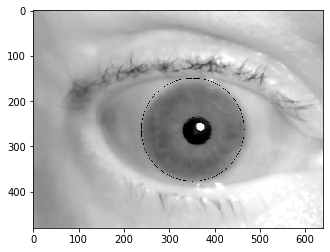

In [25]:
image = 'a.tiff'
img = cv2.imread(image,0)
img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,10,param1=63,param2=70,minRadius=0,maxRadius=0)
#  cv.HoughCircles (image, circles, method, dp, minDist, param1 = 100, param2 = 100, minRadius = 0, maxRadius = 0)
# Parameters
# image	8-bit, single-channel, grayscale input image.
# circles	output vector of found circles(cv.CV_32FC3 type). Each vector is encoded as a 3-element floating-point vector (x,y,radius) .
# method	detection method(see cv.HoughModes). Currently, the only implemented method is HOUGH_GRADIENT
# dp	inverse ratio of the accumulator resolution to the image resolution. For example, if dp = 1 , the accumulator has the same resolution as the input image. If dp = 2 , the accumulator has half as big width and height.
# minDist	minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.
# param1	first method-specific parameter. In case of HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller).
# param2	second method-specific parameter. In case of HOUGH_GRADIENT , it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
# minRadius	minimum circle radius.
# maxRadius	maximum circle radius.

height,width = img.shape
r = 0
mask = np.zeros((height,width), np.uint8)
for i in circles[0,:]:
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,0,0))
    cv2.circle(mask,(i[0],i[1]),i[2],(255,255,255),thickness=0)
    blank_image = cimg[:int(i[1]),:int(i[1])]

    masked_data = cv2.bitwise_and(cimg, cimg, mask=mask)
    _,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)
    contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(contours[0][0])
    crop = masked_data[y:y+h,x:x+w]
    r = i[2]


plt.imshow(cimg)

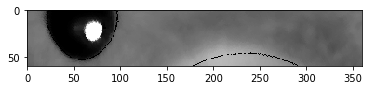

In [28]:
# liang's code for reference
def daugman_normalizaiton(image, height, width, r_in, r_out):       
    thetas = np.arange(0, 2 * np.pi, 2 * np.pi / width)  # Theta values
    r_out = r_in + r_out
    # Create empty flatten image
    flat = np.zeros((height,width, 3), np.uint8)
    circle_x = int(image.shape[0] / 2)
    circle_y = int(image.shape[1] / 2)

    for i in range(width):
        for j in range(height):
            theta = thetas[i]  # value of theta coordinate
            r_pro = j / height  # value of r coordinate(normalized)

            # get coordinate of boundaries
            Xi = circle_x + r_in * np.cos(theta)
            Yi = circle_y + r_in * np.sin(theta)
            Xo = circle_x + r_out * np.cos(theta)
            Yo = circle_y + r_out * np.sin(theta)

            # the matched cartesian coordinates for the polar coordinates
            Xc = (1 - r_pro) * Xi + r_pro * Xo
            Yc = (1 - r_pro) * Yi + r_pro * Yo

            color = image[int(Xc)][int(Yc)]  # color of the pixel

            flat[j][i] = color
    return flat  
image_nor = daugman_normalizaiton(cimg,60,360,r,55)
plt.imshow(image_nor)

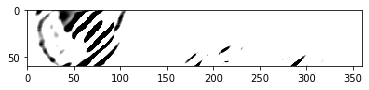

In [29]:
g_kernel = cv2.getGaborKernel((27, 27), 8.0, np.pi/4, 10.0, 0.5, 0, ktype=cv2.CV_32F)
filtered_img = cv2.filter2D(image_nor, cv2.CV_8UC3, g_kernel)

plt.imshow(image_nor)
plt.imshow(filtered_img)

h, w = g_kernel.shape[:2]
g_kernel = cv2.resize(g_kernel, (3*w, 3*h), interpolation=cv2.INTER_CUBIC)


In [30]:
from scipy.spatial import distance
distance.hamming(filtered_img.ravel(),filtered_img.ravel()) #Comparing with itself for testing purposes.


0.0